In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.graph as graph
import sim_lib.graph_create as gc
import sim_lib.graph_networkx as gnx
import sim_lib.util as util

import sim_lib.attr_lib.util as attr_util
from sim_lib.attr_lib.formation import *

In [2]:
_N = 16

attr_value_count = 1024
attr_dist_func = attr_util.pareto_dist
attr_prob = attr_dist_func(attr_value_count)
prob_func = attr_util.exp_surprise
params = {
    'attr_value_count' : attr_value_count,
    'attr_count' : 8,
    'attr_prob' : attr_prob,
    'context_switch_prob' : 0.25,
    'prob_func' : prob_func,
    'direct_cost' : 20,
    'indirect_cost' : 10
}

In [3]:
def draw_graph(G_attr, nvtx=None):
    G_attr_nx = gnx.graph_to_nx(G_attr)
    G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx)
    
    prev_pos = G_attr_vtx_pos
    prev_nodes = G_attr_nx.nodes()
    
    colors = [ 'b' ] * len(G_attr.vertices)
    
    # Get position of new vertex
    # Calculate positions as if all new, use this position for new vertex
    if nvtx is not None:
        k_dist = 1 / (5 * np.sqrt(G_attr.num_people))
        G_attr_vtx_pos_recalc = nx.drawing.layout.spring_layout(G_attr_nx, k=k_dist)
        prev_pos[nvtx] = G_attr_vtx_pos_recalc[nvtx]

        nvtx_idx = list(G_attr_nx.nodes()).index(nvtx)
        colors[nvtx_idx] = 'r'
        
    prev_pos = nx.drawing.layout.spring_layout(G_attr_nx)
    G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx,
                                                     pos=prev_pos, fixed=prev_nodes)
    
    # Draw graph
    plt.figure(figsize=(15,15))
    nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos, node_color=colors,
                     node_size=40, width=0.6, with_labels=None)

<function uniform_dist at 0x7ff8fb61dd90> 2 1
[0.5, 0.5]
<function uniform_dist at 0x7ff8fb61dd90> 1024 1
<function uniform_dist at 0x7ff8fb61dd90> 1024 32
<function pareto_dist at 0x7ff8fb61dd08> 2 1
[0.74344683 0.25655317]
<function pareto_dist at 0x7ff8fb61dd08> 1024 1
<function pareto_dist at 0x7ff8fb61dd08> 1024 32


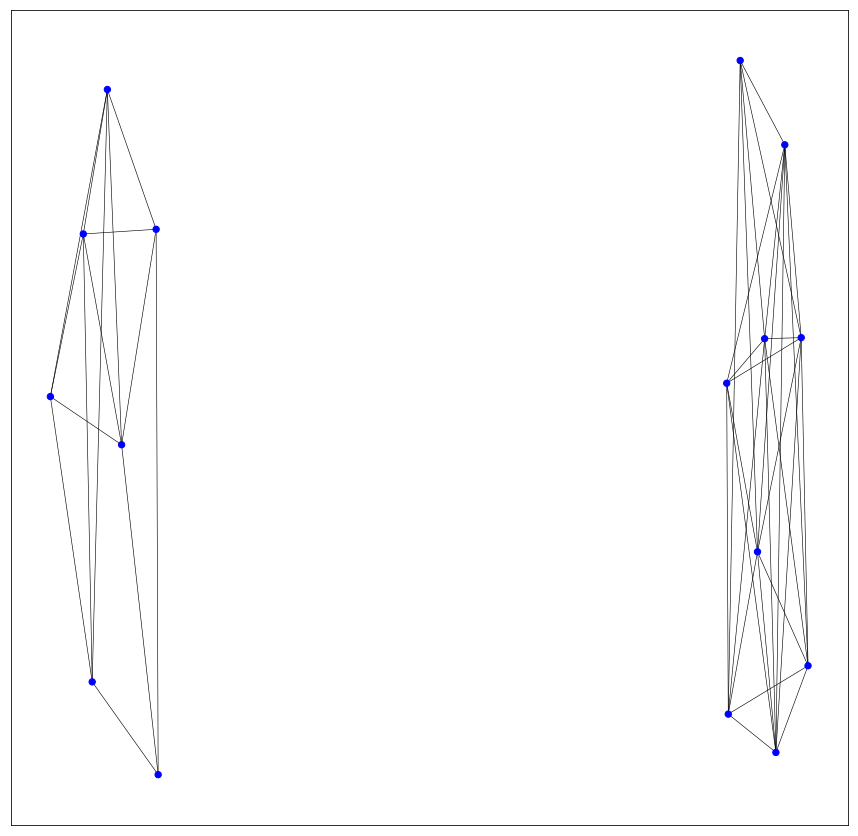

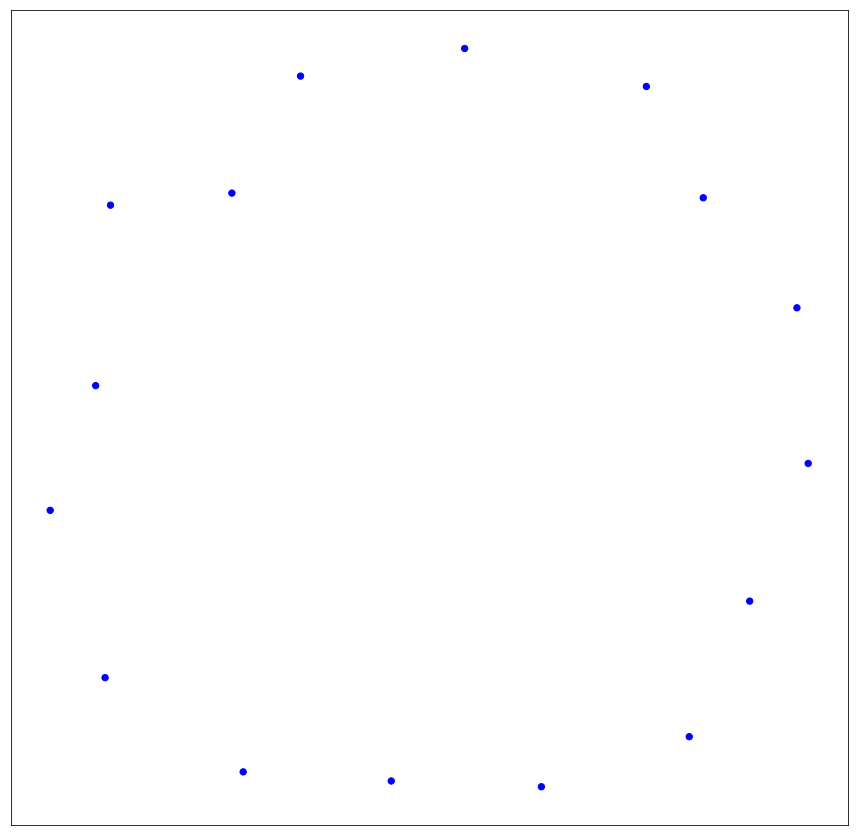

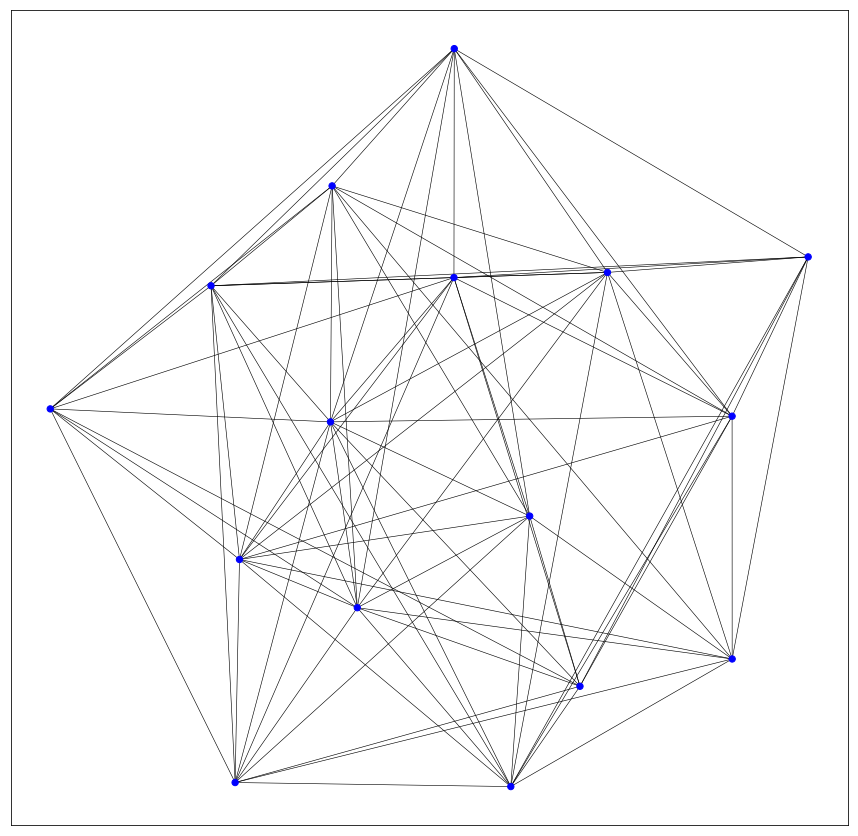

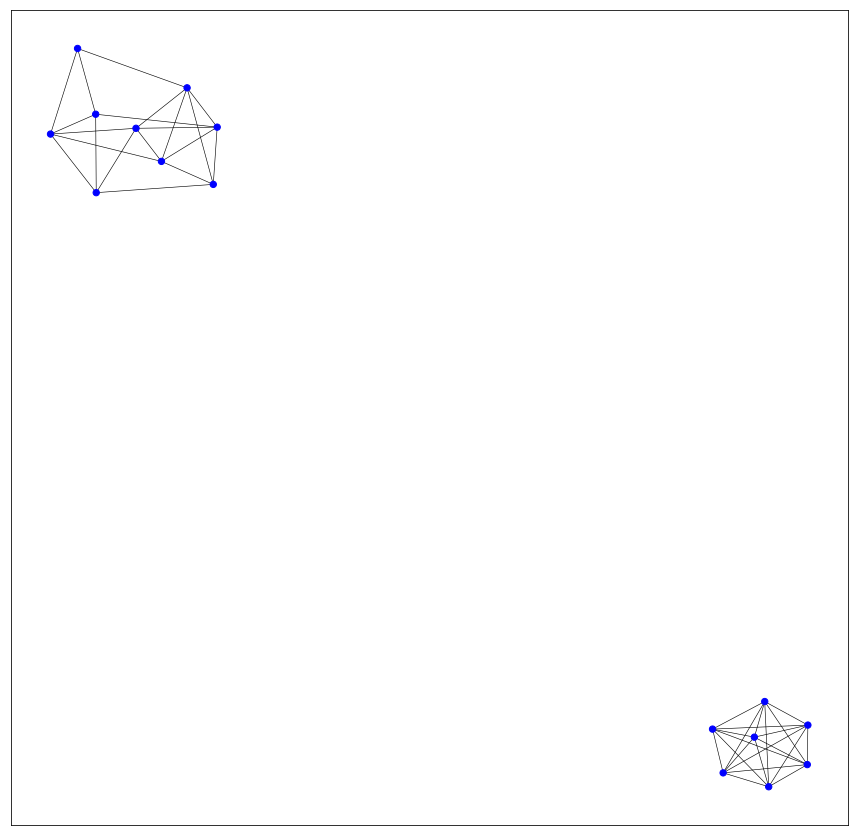

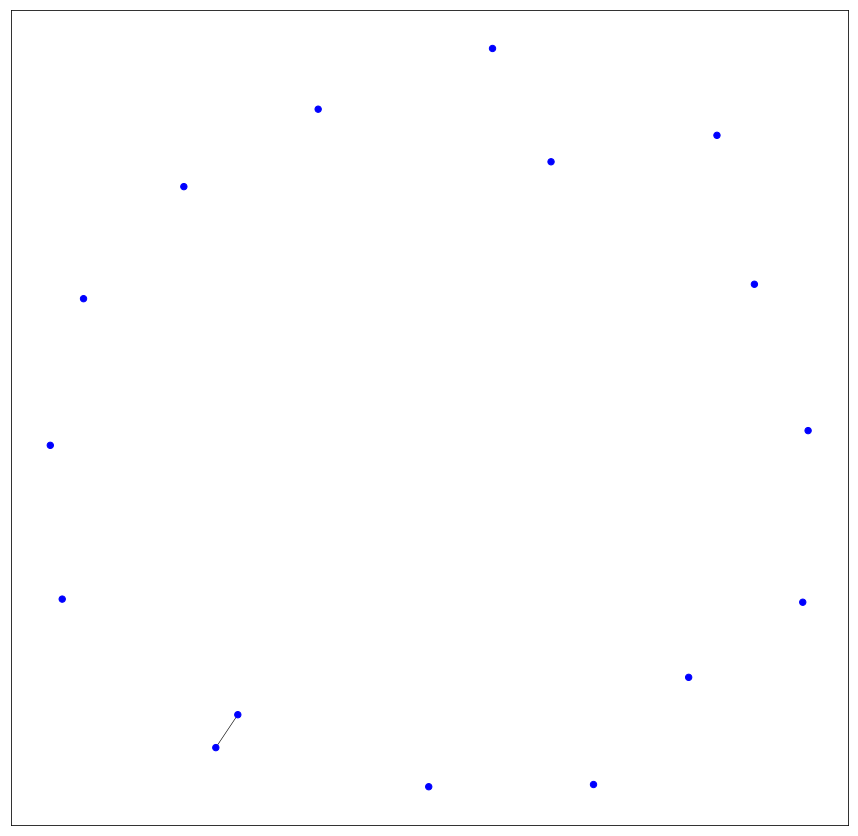

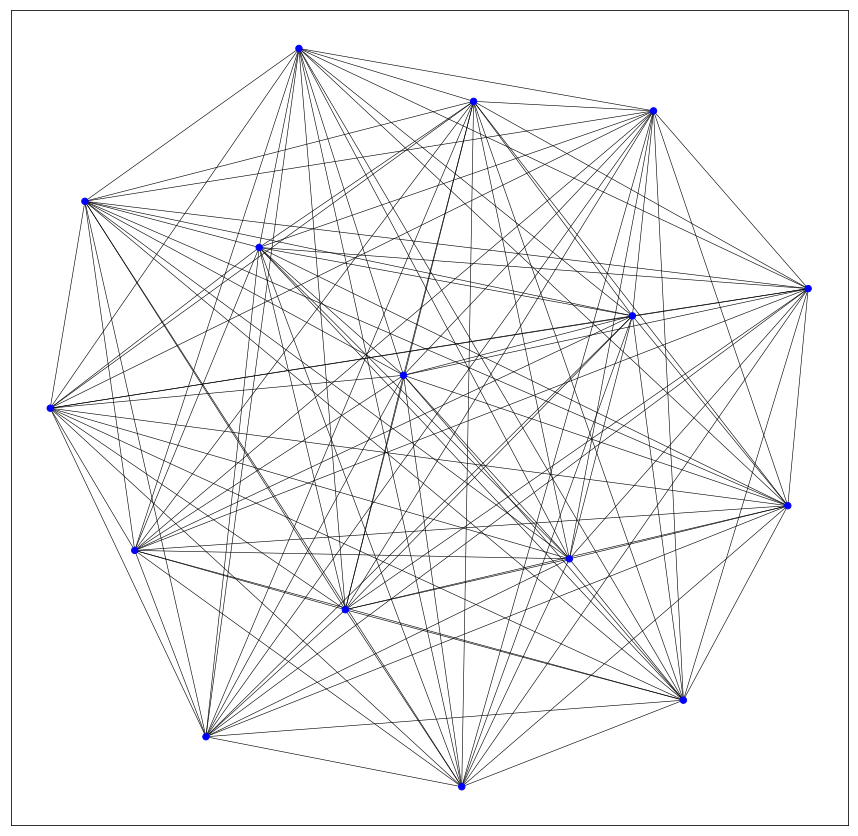

In [4]:
dist_funcs = [attr_util.uniform_dist, attr_util.pareto_dist]
attr_counts = [2, 1024]
context_counts = [1, 32]

for df in dist_funcs:
    for ac in attr_counts:
        for cc in context_counts:
            if cc > ac:
                continue
            print(df, ac, cc)
            attr_prob = df(ac)
            if ac == 2:
                print(attr_prob)
            params = {
                'attr_value_count' : ac,
                'attr_count' : cc,
                'attr_prob' : attr_prob,
                'context_switch_prob' : 0.25,
                'prob_func' : prob_func,
                'direct_cost' : 20,
                'indirect_cost' : 10
            }
            G_attr = attribute_block_graph(_N, params)
            draw_graph(G_attr)